# ART GRAPHITE Whitebox Attack

Install Kornia, an open source Differentiable Computer Vision Library for PyTorch


In [ ]:
pip install kornia

Setup and load the data and train a model to test on.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from art.attacks.evasion import GRAPHITEWhiteboxPyTorch
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist


# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

# Step 2: Create the model

model = nn.Sequential(
    nn.Conv2d(1, 4, 5), nn.ReLU(), nn.MaxPool2d(2, 2),
    nn.Conv2d(4, 10, 5), nn.ReLU(), nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(4*4*10, 100),
    nn.Linear(100, 10)
)
# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=5)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 97.6%


# Get Init Image

Second, load an initialization image to attack.

Init image is:  7


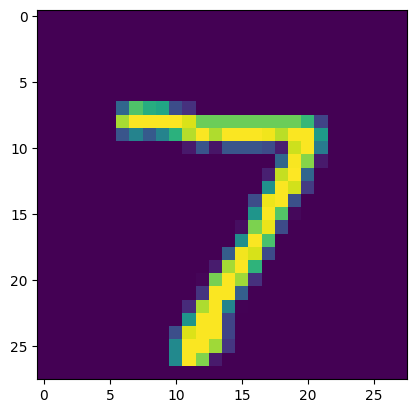

Target label is:  2


In [ ]:
init_image = x_test[0, :, :, :]

print("Init image is: ", np.argmax(classifier.predict(np.array([init_image]))[0]))
plt.imshow((init_image.squeeze() * 255).astype(np.uint))
plt.show()

target_label_index = np.argmax(y_test[1])
target_label = target_label_index.item()
print("Target label is: ", target_label)

# Run GRAPHITE Whitebox Attack

Finally, run an attack on a GRAHPITEWhiteboxPyTorch instance. We set the network size to 28 x 28 for MNIST and set the inner EoT PGD steps to 50. The attack is shown at the end.

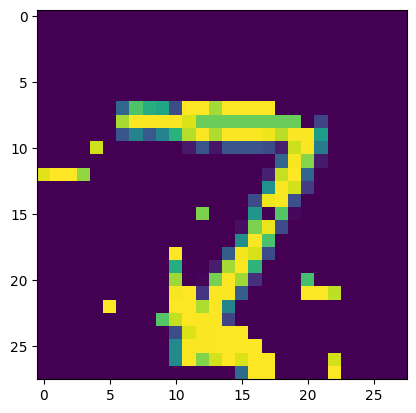

Predicted label is:  2


In [ ]:
# Step 6: Generate adversarial test examples
attack = GRAPHITEWhiteboxPyTorch(
    classifier,
    (28, 28),
    patch_removal_size = 4,
    patch_removal_interval = 1,
    steps = 50
)

x_test_adv = attack.generate(x=x_test[0, :, :, :][np.newaxis, :, :, :], y=y_test[1][np.newaxis, :], mask=None)
plt.imshow(x_test_adv[0,...].squeeze())
plt.show()

predicted_label = np.argmax(classifier.predict(np.array([x_test_adv[0, ...]]))[0])
print("Predicted label is: ", predicted_label)